In [540]:
import hydra
import torch

import numpy as np
import pandas as pd
import plotnine as pn

from hydra.core.global_hydra import GlobalHydra

# Lets us import ibsg modules
import sys
sys.path.append("/Users/nathanielimel/uci/projects/ibsg/src")

from game.game import Game

In [541]:
all_data_fp = "../../analysis_data/all_data.csv"
df = pd.read_csv(all_data_fp)
df

/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_77437/1048885480.py:2: DtypeWarning: Columns (10,16,20) have mixed types. Specify dtype option on import or set low_memory=False.


,complexity,accuracy,distortion,mse,gNID,eps,beta,run,point_type,round,...,num_signals,distance,discriminative_need_gamma,meaning_dist_gamma,dynamics,imprecise_imitation_gamma,population_init_gamma,seed,ib_bound_function,min_distance_to_curve
0,0.302817,0.285931,1.626097,10.196382,0.026481,-0.009173,0.749013,0.0,simulation,NaN,...,10,squared_dist,0.0,0,replicator_diffusion,-1.0,2.0,42.0,NaN,NaN
1,2.704773,1.499383,0.412644,9.724241,NaN,NaN,NaN,1.0,trajectory,0.0,...,10,squared_dist,0.0,0,replicator_diffusion,-1.0,2.0,42.0,NaN,NaN
2,0.203795,0.189977,1.722051,11.818519,NaN,NaN,NaN,1.0,trajectory,1.0,...,10,squared_dist,0.0,0,replicator_diffusion,-1.0,2.0,42.0,NaN,NaN
3,0.151592,0.142945,1.769083,12.727127,NaN,NaN,NaN,1.0,trajectory,2.0,...,10,squared_dist,0.0,0,replicator_diffusion,-1.0,2.0,42.0,NaN,NaN
4,0.151410,0.143119,1.768909,12.660234,NaN,NaN,NaN,1.0,trajectory,3.0,...,10,squared_dist,0.0,0,replicator_diffusion,-1.0,2.0,42.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256502,0.085732,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,mse_bound,NaN,...,500,squared_dist,NaN,0,NaN,NaN,NaN,NaN,embo,NaN
256503,0.085732,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,mse_bound,NaN,...,500,squared_dist,NaN,0,NaN,NaN,NaN,NaN,embo,NaN
256504,0.085732,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,mse_bound,NaN,...,500,squared_dist,NaN,0,NaN,NaN,NaN,NaN,embo,NaN
256505,0.085732,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,mse_bound,NaN,...,500,squared_dist,NaN,0,NaN,NaN,NaN,NaN,embo,NaN


In [542]:
def get_df_subsetted_by_meaning_dists(df: pd.DataFrame, curve_metadata) -> pd.DataFrame:
    """Return a subset of the data consistent with the specifications in the curve_metadata config."""

    # See src/get_all_data.py
    universe = df["universe"].astype(str) == str(curve_metadata.universe)
    prior = df["prior"].astype(str) == str(curve_metadata.prior)
    num_signals = df["num_signals"] == curve_metadata.num_signals # this is prob not necessary
    distance = df["distance"] == curve_metadata.distance

    meaning_dist_gamma = df["meaning_dist_gamma"] == curve_metadata.meaning_dist_gamma


    # imprecise_imitation_gamma = df["imprecise_imitation_gamma"].isin([curve_metadata.meaning_dist_gamma, torch.nan]) # allows curve

    bound_func = df["ib_bound_function"].isin([curve_metadata.ib_bound_function, torch.nan]) # check for 'embo', 'homebuilt' for curves, nan for all simulations since those are curve agnostic.

    # df_subsetted = df[universe & prior & num_signals & num_signals & distance & meaning_dist_gamma & imprecise_imitation_gamma & bound_func]
    df_subsetted = df[universe & prior & num_signals & num_signals & distance & meaning_dist_gamma & bound_func]

    return df_subsetted

In [543]:
overrides = [
    "game.universe=100",
    "game.num_signals=100",
    "game.meaning_dist_gamma=-1",
    # "simulation/dynamics=nowak_krakauer"
] # n.b.: do not include multirun overrides, we will filter from columns in the dataframe.

# Global initialization
GlobalHydra.instance().clear() # from previous runs of notebook
hydra.initialize(version_base=None, config_path="../../conf")
config = hydra.compose(
    config_name="config",
    overrides=overrides,
)

curve_metadata = config.game

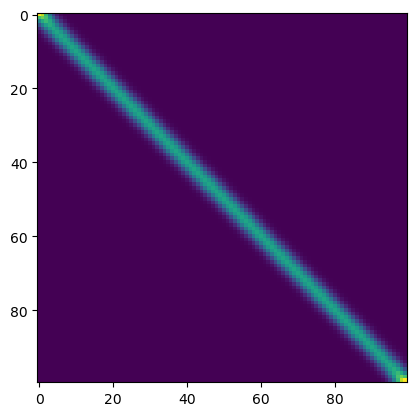

In [544]:
%matplotlib inline
import matplotlib.pyplot as plt

game = Game.from_hydra(config, cwd="/Users/nathanielimel/uci/projects/ibsg/data")
plt.imshow(game.meaning_dists)

In [545]:
# visualize the curve!
df = get_df_subsetted_by_meaning_dists(df, curve_metadata)
df

,complexity,accuracy,distortion,mse,gNID,eps,beta,run,point_type,round,...,num_signals,distance,discriminative_need_gamma,meaning_dist_gamma,dynamics,imprecise_imitation_gamma,population_init_gamma,seed,ib_bound_function,min_distance_to_curve
98429,2.983018,2.714889,0.765883,28.566874,0.000246,-0.000213,1.03033,0.0,simulation,NaN,...,100,squared_dist,0.0,-1,replicator_diffusion,-1.0,2.0,42.0,NaN,NaN
98430,5.794949,2.692982,0.787791,1666.672700,NaN,NaN,NaN,1.0,trajectory,0.0,...,100,squared_dist,0.0,-1,replicator_diffusion,-1.0,2.0,42.0,NaN,0.762977
98431,2.982665,2.654732,0.826041,36.916454,NaN,NaN,NaN,1.0,trajectory,1.0,...,100,squared_dist,0.0,-1,replicator_diffusion,-1.0,2.0,42.0,NaN,0.051031
98432,2.944073,2.665729,0.815043,31.143974,NaN,NaN,NaN,1.0,trajectory,2.0,...,100,squared_dist,0.0,-1,replicator_diffusion,-1.0,2.0,42.0,NaN,0.020274
98433,2.925965,2.667463,0.813310,30.368370,NaN,NaN,NaN,1.0,trajectory,3.0,...,100,squared_dist,0.0,-1,replicator_diffusion,-1.0,2.0,42.0,NaN,0.010209
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235378,6.643856,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,mse_bound,NaN,...,100,squared_dist,NaN,-1,NaN,NaN,NaN,NaN,embo,NaN
235379,6.643856,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,mse_bound,NaN,...,100,squared_dist,NaN,-1,NaN,NaN,NaN,NaN,embo,NaN
235380,6.643856,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,mse_bound,NaN,...,100,squared_dist,NaN,-1,NaN,NaN,NaN,NaN,embo,NaN
235381,6.643856,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,mse_bound,NaN,...,100,squared_dist,NaN,-1,NaN,NaN,NaN,NaN,embo,NaN


In [546]:
df_final_points = df[df["point_type"] == "simulation"]
df_ib_bound = df[df["point_type"] == "ib_bound"]
df_mse_bound = df[df["point_type"] == "mse_bound"]

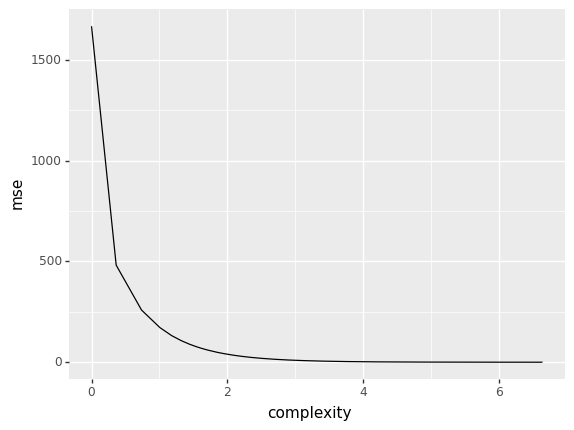

<ggplot: (738252650)>

In [547]:
(
    pn.ggplot(df_mse_bound, pn.aes(x="complexity", y="mse"))
    + pn.geom_line()
)

In [548]:
langs = df_final_points[df_final_points["population_init_gamma"] == -3]
langs

,complexity,accuracy,distortion,mse,gNID,eps,beta,run,point_type,round,...,num_signals,distance,discriminative_need_gamma,meaning_dist_gamma,dynamics,imprecise_imitation_gamma,population_init_gamma,seed,ib_bound_function,min_distance_to_curve
99439,2.986792,2.717480,0.763293,28.464336,0.000852,0.000937,1.030330,0.0,simulation,NaN,...,100,squared_dist,0.0,-1,replicator_diffusion,-1.0,-3.0,42.0,NaN,NaN
100853,3.006411,2.730202,0.750571,27.982586,0.000946,0.001526,1.039640,0.0,simulation,NaN,...,100,squared_dist,1.0,-1,replicator_diffusion,-1.0,-3.0,42.0,NaN,NaN
102267,2.865984,2.635402,0.845371,31.872898,0.000913,-0.000414,0.974474,0.0,simulation,NaN,...,100,squared_dist,-1.0,-1,replicator_diffusion,-1.0,-3.0,42.0,NaN,NaN
103681,1.817033,1.767319,1.713454,108.897040,0.006658,-0.011715,0.766633,0.0,simulation,NaN,...,100,squared_dist,-3.0,-1,replicator_diffusion,-1.0,-3.0,42.0,NaN,NaN
105095,3.006472,2.730240,0.750533,27.981320,0.000956,0.001548,1.039640,0.0,simulation,NaN,...,100,squared_dist,3.0,-1,replicator_diffusion,-1.0,-3.0,42.0,NaN,NaN
106509,3.006421,2.730206,0.750565,27.982490,0.000949,0.001533,1.039640,0.0,simulation,NaN,...,100,squared_dist,2.0,-1,replicator_diffusion,-1.0,-3.0,42.0,NaN,NaN
107923,2.456497,2.324482,1.156291,49.254143,0.001286,-0.004687,0.853012,0.0,simulation,NaN,...,100,squared_dist,-2.0,-1,replicator_diffusion,-1.0,-3.0,42.0,NaN,NaN
108895,0.343580,0.341563,3.139210,942.122900,0.611535,-0.011960,0.683122,0.0,simulation,NaN,...,100,squared_dist,0.0,-1,replicator_diffusion,-3.0,-3.0,42.0,NaN,NaN
109488,0.346839,0.344801,3.135972,937.714230,0.614859,-0.011926,0.683122,0.0,simulation,NaN,...,100,squared_dist,1.0,-1,replicator_diffusion,-3.0,-3.0,42.0,NaN,NaN
110202,0.333408,0.331461,3.149312,955.957200,0.600743,-0.012062,0.683122,0.0,simulation,NaN,...,100,squared_dist,-1.0,-1,replicator_diffusion,-3.0,-3.0,42.0,NaN,NaN


/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/plotnine/stats/smoothers.py:321: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.


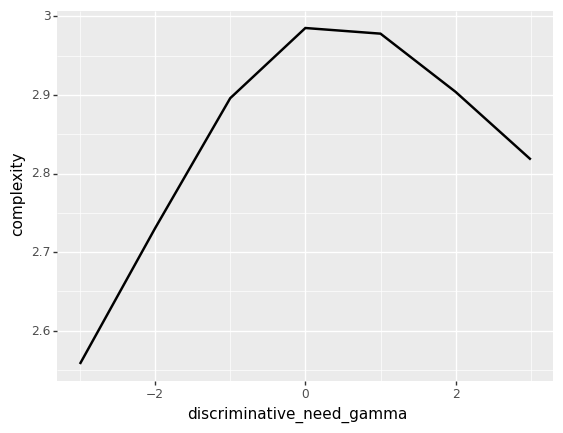

<ggplot: (713922242)>

In [549]:
(
    pn.ggplot(df_final_points, pn.aes(x="discriminative_need_gamma", y="complexity"))
    + pn.geom_smooth()
)

In [550]:
df_final_points["discriminative_need_gamma"] = 10 ** df_final_points["discriminative_need_gamma"]
df_final_points["imprecise_imitation_gamma"] = 10 ** df_final_points["imprecise_imitation_gamma"]

In [551]:
# restrict dynamics
df_final_points = df_final_points[df_final_points["dynamics"] == "replicator_diffusion"]

# Only run this if you're visualizing by discr need and fixing ii to -1
df_final_points = df_final_points[df_final_points["imprecise_imitation_gamma"] == 10 ** -1]

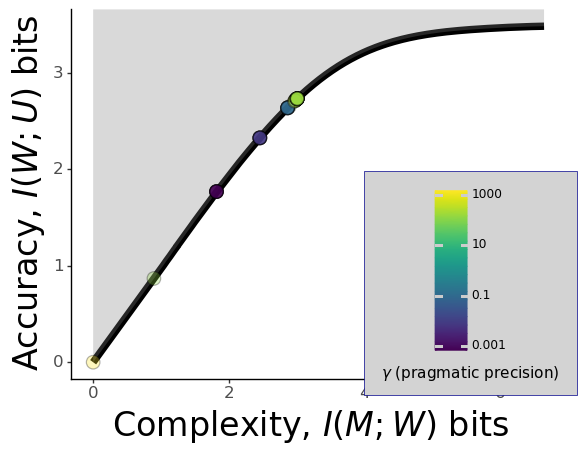

/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6 x 6 in image.
/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: evolang_figure


In [552]:
plot = (
    # Set data and the axes
    pn.ggplot(
        data=df_ib_bound, mapping=pn.aes(x="complexity", y="accuracy")
    )  
    + pn.geom_line(size=3) # IB curve
    + pn.geom_ribbon(
    mapping=pn.aes(
        x="complexity",
        ymin="accuracy",
        ymax=torch.inf,
        ),
        fill="gray",
        alpha=0.3,
    )
    + pn.geom_point( # emergent langs
        data=df_final_points,
        mapping=pn.aes(
            fill="discriminative_need_gamma",
            # fill="imprecise_imitation_gamma",
            ),
        alpha=0.3,
        size=5,
    )
    + pn.labs(fill="$\\gamma$ (pragmatic precision)")
    # + pn.labs(fill="$\\alpha$ (perceptual certainty)")    
    + pn.scale_fill_continuous(
        trans = "log10",
    )
    + pn.xlim([0,np.log2(100)])
    + pn.xlab("Complexity, $I(M;W)$ bits")
    + pn.ylab("Accuracy, $I(W;U)$ bits")

    + pn.theme_classic()
    + pn.theme(
        # Axis font
        axis_title=pn.element_text(size=24),
        axis_text=pn.element_text(size=12),
        # Legend position
        legend_position=(0.75, 0.31),
        # legend_position='none',
        legend_direction = "vertical",
        # Legend box
        legend_background=pn.element_rect(
            fill="lightgrey",
            size=0.5, linetype="solid", 
            color="darkblue",
        ),
    )
    # guide not working, maybe should just use R
    + pn.guides(
        fill = pn.guide_colorbar(
            title_position = "bottom", 
            label_position = "bottom",
            override_aes = {"alpha":0.8},
            ),
    ) 
)
print(plot)
plot.save("evolang_figure", width=6, height=6, dpi=300,)

In [553]:
# restrict to one specific gamma at a time
gammas = [
    0.001,
    0.01,
    0.1,
    1.0,
    10.0,
    100.0,
    1000.0,
]
df_final_points = df_final_points[df_final_points["discriminative_need_gamma"].isin(gammas)]

In [554]:
# df_final_points = df_final_points[df_final_points["population_init_gamma"] == -3]
df_final_points

,complexity,accuracy,distortion,mse,gNID,eps,beta,run,point_type,round,...,num_signals,distance,discriminative_need_gamma,meaning_dist_gamma,dynamics,imprecise_imitation_gamma,population_init_gamma,seed,ib_bound_function,min_distance_to_curve
98429,2.983018e+00,2.714889,0.765883,28.566874,0.000246,-0.000213,1.030330,0.0,simulation,NaN,...,100,squared_dist,1.000,-1,replicator_diffusion,0.1,2.0,42.0,NaN,NaN
98631,2.967996e+00,2.704632,0.776141,28.946053,0.001692,0.000989,1.021021,0.0,simulation,NaN,...,100,squared_dist,1.000,-1,replicator_diffusion,0.1,3.0,42.0,NaN,NaN
98833,2.986751e+00,2.717451,0.763322,28.465515,0.000845,0.000923,1.030330,0.0,simulation,NaN,...,100,squared_dist,1.000,-1,replicator_diffusion,0.1,-1.0,42.0,NaN,NaN
99035,2.986381e+00,2.717225,0.763548,28.472992,0.000788,0.000784,1.030330,0.0,simulation,NaN,...,100,squared_dist,1.000,-1,replicator_diffusion,0.1,1.0,42.0,NaN,NaN
99237,2.986809e+00,2.717487,0.763286,28.464333,0.000854,0.000944,1.030330,0.0,simulation,NaN,...,100,squared_dist,1.000,-1,replicator_diffusion,0.1,0.0,42.0,NaN,NaN
99439,2.986792e+00,2.717480,0.763293,28.464336,0.000852,0.000937,1.030330,0.0,simulation,NaN,...,100,squared_dist,1.000,-1,replicator_diffusion,0.1,-3.0,42.0,NaN,NaN
99641,2.986773e+00,2.717467,0.763306,28.464783,0.000849,0.000929,1.030330,0.0,simulation,NaN,...,100,squared_dist,1.000,-1,replicator_diffusion,0.1,-2.0,42.0,NaN,NaN
99843,2.994813e+00,2.722554,0.758219,28.252380,0.001480,-0.002274,1.039640,0.0,simulation,NaN,...,100,squared_dist,10.000,-1,replicator_diffusion,0.1,2.0,42.0,NaN,NaN
100045,2.888819e+00,2.647658,0.833114,30.971634,0.006171,-0.002129,0.993093,0.0,simulation,NaN,...,100,squared_dist,10.000,-1,replicator_diffusion,0.1,3.0,42.0,NaN,NaN
100247,3.006444e+00,2.730221,0.750552,27.981976,0.000951,0.001539,1.039640,0.0,simulation,NaN,...,100,squared_dist,10.000,-1,replicator_diffusion,0.1,-1.0,42.0,NaN,NaN


In [555]:
df_final_points["discriminative_need_gamma"] = df_final_points["discriminative_need_gamma"].astype(str)

In [556]:
# this is a dirty and beautiful hack from
# https://waldyrious.net/viridis-palette-generator/
fill_values_dict = {
    str(k): v for k, v in {
        "0.001": "#440154",
        "0.01": "#443983",
        "0.1": "#31688e",
        "1.0": "#21918c",
        "10.0": "#35b779",
        "100.0" : "#90d743",
        "1000.0": "#fde725", 
    }.items() }


In [557]:
# Make sure complexity max is np.log2(100)
df_ib_bound.complexity.max()

6.643729834424851

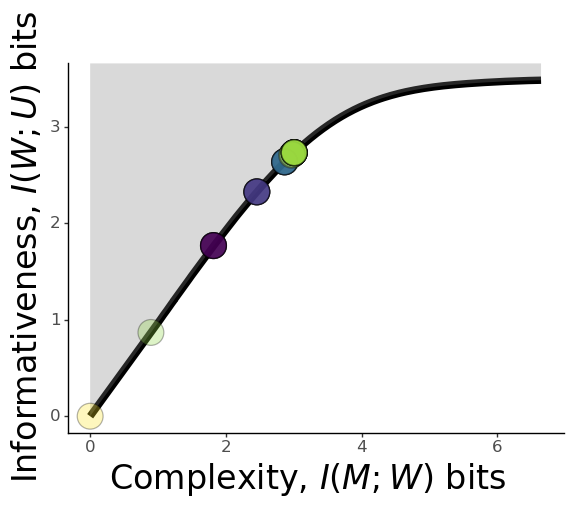

/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 10 x 10 in image.
/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: slide_figure


In [558]:
# for slides

plot = (
    # Set data and the axes
    pn.ggplot(
        data=df_ib_bound, mapping=pn.aes(x="complexity", y="accuracy")
    )  
    + pn.geom_line(size=3) # IB curve
    # + pn.geom_point(size=1)
    + pn.geom_ribbon(
    mapping=pn.aes(
        x="complexity",
        ymin="accuracy",
        ymax=torch.inf,
        ),
        fill="gray",
        alpha=0.3,
    )
)

if True:
    plot = (
        plot 
        + pn.geom_jitter( # emergent langs
            data=df_final_points,
            mapping=pn.aes(
                # fill="discr_need",
                fill="discriminative_need_gamma",
                # shape="language",
                ),
            alpha=0.3,
            size=10,
            # fill="orange",
        )
        + pn.labs(fill="$\\gamma$ (pragmatic precision)")
        # + pn.scale_fill_continuous(
        #     trans = "log10",
        # )
        + pn.scale_fill_manual(values = fill_values_dict) 
    )
    
plot = (
    plot
    + pn.xlim([0,np.log2(100)])
    + pn.xlab("Complexity, $I(M;W)$ bits")
    # + pn.ylab("Accuracy, $I(W;U)$ bits")
    + pn.ylab("Informativeness, $I(W;U)$ bits")


    + pn.theme_classic()
    + pn.theme(
        # Axis font
        axis_title=pn.element_text(size=24),
        axis_text=pn.element_text(size=12),
        # Legend position
        # legend_position=(0.75, 0.4),
        legend_position='none',
    )    
)

print(plot)
plot.save("slide_figure", width=10, height=10, dpi=300,)

# df_final_points["discriminative_need_gamma"] = df_final_points["discriminative_need_gamma"].astype(float)

In [559]:
df_traj_points = df[df["point_type"] == "trajectory"]

df_traj_points["iteration"] = df_traj_points["round"]

# restrict dynamics
df_traj_points = df_traj_points[df_traj_points["dynamics"] == "replicator_diffusion"]

# restrict the initialization and gamma
new_df = df_traj_points.loc[(df_traj_points['population_init_gamma'] == -3) & (df_traj_points["discriminative_need_gamma"] == 3) & (df_traj_points["imprecise_imitation_gamma"] == -1)]


# optionally filter points
# new_df = new_df[new_df["iteration"] == new_df["iteration"].max()]


In [560]:
df_fudge = pd.DataFrame(
    {
        "complexity": 0.,
        "accuracy": 0.,
        "point_type": "trajectory",
        "round": 0.,
        "discriminative_need_gamma": -3.0,
        "population_init_gamma": 3.0,
        "iteration": 0.,
    },
    index=[0]
)
df_fudge
# new_df = pd.concat([df_fudge, new_df])

new_df

,complexity,accuracy,distortion,mse,gNID,eps,beta,run,point_type,round,...,distance,discriminative_need_gamma,meaning_dist_gamma,dynamics,imprecise_imitation_gamma,population_init_gamma,seed,ib_bound_function,min_distance_to_curve,iteration
105096,0.000000,0.000000,3.480774,1664.715300,NaN,NaN,NaN,1.0,trajectory,0.0,...,squared_dist,3.0,-1,replicator_diffusion,-1.0,-3.0,42.0,NaN,3.468103e-15,0.0
105097,0.000000,0.000000,3.480773,1663.542100,NaN,NaN,NaN,1.0,trajectory,1.0,...,squared_dist,3.0,-1,replicator_diffusion,-1.0,-3.0,42.0,NaN,3.468103e-15,1.0
105098,0.000000,0.000000,3.480773,1662.632700,NaN,NaN,NaN,1.0,trajectory,2.0,...,squared_dist,3.0,-1,replicator_diffusion,-1.0,-3.0,42.0,NaN,3.468103e-15,2.0
105099,0.000004,0.000004,3.480769,1661.873900,NaN,NaN,NaN,1.0,trajectory,3.0,...,squared_dist,3.0,-1,replicator_diffusion,-1.0,-3.0,42.0,NaN,1.671550e-07,3.0
105100,0.000020,0.000019,3.480754,1661.206400,NaN,NaN,NaN,1.0,trajectory,4.0,...,squared_dist,3.0,-1,replicator_diffusion,-1.0,-3.0,42.0,NaN,3.377727e-07,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105291,3.006478,2.730243,0.750530,27.981220,NaN,NaN,NaN,1.0,trajectory,195.0,...,squared_dist,3.0,-1,replicator_diffusion,-1.0,-3.0,42.0,NaN,4.323893e-03,195.0
105292,3.006475,2.730242,0.750531,27.981245,NaN,NaN,NaN,1.0,trajectory,196.0,...,squared_dist,3.0,-1,replicator_diffusion,-1.0,-3.0,42.0,NaN,4.320938e-03,196.0
105293,3.006473,2.730239,0.750534,27.981274,NaN,NaN,NaN,1.0,trajectory,197.0,...,squared_dist,3.0,-1,replicator_diffusion,-1.0,-3.0,42.0,NaN,4.317879e-03,197.0
105294,3.006473,2.730240,0.750533,27.981295,NaN,NaN,NaN,1.0,trajectory,198.0,...,squared_dist,3.0,-1,replicator_diffusion,-1.0,-3.0,42.0,NaN,4.318336e-03,198.0


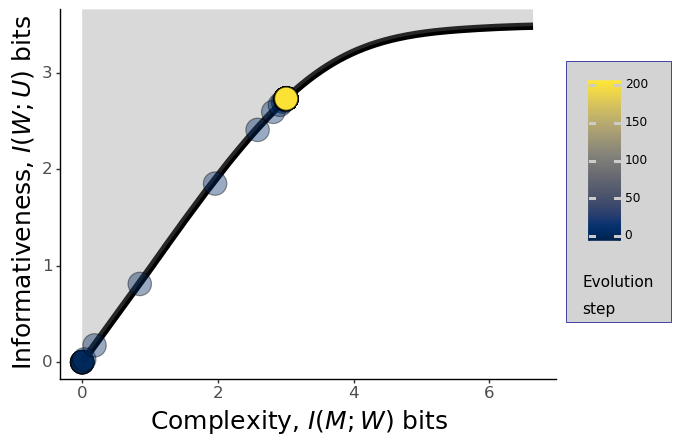

/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6 x 6 in image.
/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: temp_slide_traj


In [561]:

plot = (
    # Set data and the axes
    pn.ggplot(
        data=df_ib_bound, mapping=pn.aes(x="complexity", y="accuracy")
    )
    # + pn.geom_point(size=1)
    + pn.geom_line(size=3) # IB curve    
    + pn.geom_ribbon(
    mapping=pn.aes(
        x="complexity",
        ymin="accuracy",
        ymax=torch.inf,
        ),
        fill="gray",
        alpha=0.3,
    )
    + pn.geom_point( # trajectories
    # + pn.geom_line(
        data=new_df,
        mapping=pn.aes(
            fill="iteration",
            # color="imprecise_imitation_gamma"
            # color="population_init_gamma",
            ),
        alpha=0.4,
        size=9,
    )
    # + pn.labs(fill="iteration")
    # + pn.scale_fill_continuous("cividis")
    + pn.scale_fill_continuous(
        "cividis",
        breaks=[0, 50, 100, 150, 200],
        limits=[0, 200],
    )
    + pn.labs(fill="Evolution\n\nstep\n")
    + pn.xlim([0,np.log2(100)])
    + pn.xlab("Complexity, $I(M;W)$ bits")
    # + pn.ylab("Accuracy, $I(W;U)$ bits")
    + pn.ylab("Informativeness, $I(W;U)$ bits")
    + pn.theme_classic()
    + pn.theme(
        # Axis font
        axis_title=pn.element_text(size=18),
        axis_text=pn.element_text(size=12),
        # Legend position
        # legend_position=(0.75, 0.45),
        legend_position='none',
        legend_direction = "vertical",
        # Legend box
        legend_background=pn.element_rect(
            fill="lightgrey",
            size=0.5, 
            linetype="solid", 
            color="darkblue",
        ),
    )
    # guide not working, maybe should just use R
    + pn.guides(
        # fill = pn.guide_legend(
        fill = pn.guide_colorbar(
            title_position = "bottom",
            # hjust = 0.5 centers the title horizontally
            title_hjust = 0.8,
            title_vjust = -2.,
            label_position = "bottom",
            override_aes = {"alpha":0.8},
            # nrow=3,
            ),
    ) 
)
print(plot)
plot.save("temp_slide_traj", width=6, height=6, dpi=300,)

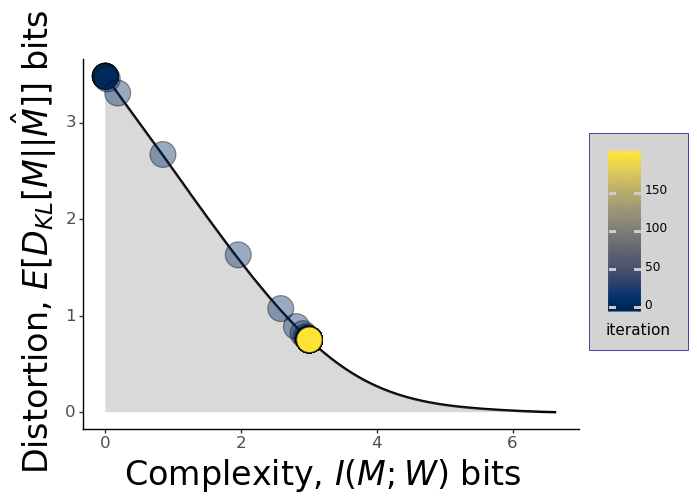

In [562]:

plot = (
    # Set data and the axes
    pn.ggplot(
        data=df_ib_bound, mapping=pn.aes(x="complexity", y="distortion")
    )  
    # + pn.geom_point(size=1)
    + pn.geom_line(size=1) # IB curve    
    + pn.geom_ribbon(
    mapping=pn.aes(
        x="complexity",
        ymin=0,
        ymax="distortion",
        ),
        fill="gray",
        alpha=0.3,
    )
    + pn.geom_point( # trajectories
    # + pn.geom_line(
        data=new_df,
        mapping=pn.aes(
            fill="iteration",
            # color="imprecise_imitation_gamma"
            # color="population_init_gamma",
            ),
        alpha=0.4,
        size=10,
    )
    + pn.scale_fill_continuous("cividis")
    # + pn.labs(fill="iteration")
    # + pn.scale_fill_continuous(
    #     type="magma",
    #     breaks=[0, 50, 100, 150, 200],
    #     limits=[0, 200],
    # )
    + pn.xlab("Complexity, $I(M;W)$ bits")
    + pn.ylab("Distortion, $E[D_{KL}[M || \hat{M}]]$ bits")

    + pn.theme_classic()
    + pn.theme(
        # Axis font
        axis_title=pn.element_text(size=24),
        axis_text=pn.element_text(size=12),
        # Legend position
        # legend_position=(0.75, 0.325),
        # legend_position='none',
        legend_direction = "vertical",
        # Legend box
        legend_background=pn.element_rect(
            fill="lightgrey",
            size=0.5, linetype="solid", 
            color="darkblue",
        ),
    )
    # guide not working, maybe should just use R
    + pn.guides(
        # fill = pn.guide_legend(
        fill = pn.guide_colorbar(
            title_position = "bottom", 
            # hjust = 0.5 centers the title horizontally
            title_hjust = 0.8,
            title_vjust = 2.,
            label_position = "bottom",
            override_aes = {"alpha":0.8},
            # nrow=3,
            ),
    ) 
)
print(plot)

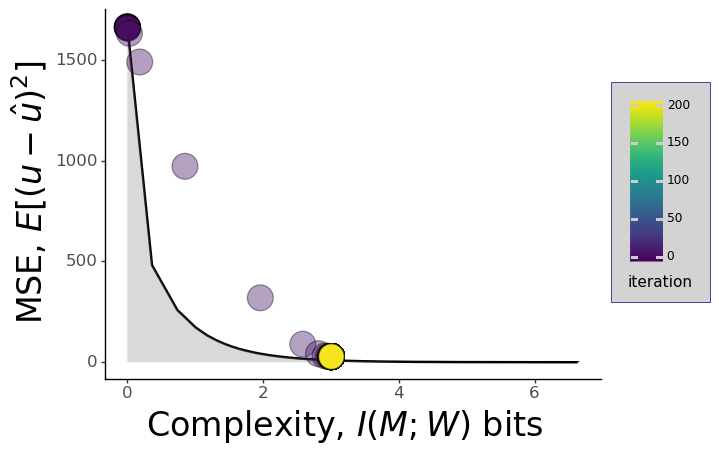

In [563]:

plot = (
    # Set data and the axes
    pn.ggplot(
        data=df_mse_bound, mapping=pn.aes(x="complexity", y="mse")
    )  
    # + pn.geom_point(size=1)
    + pn.geom_line(size=1) # IB curve
    + pn.geom_ribbon(
    mapping=pn.aes(
        x="complexity",
        ymin=0,
        ymax="mse",
        ),
        fill="gray",
        alpha=0.3,
    )
    + pn.geom_point( # trajectories
    # + pn.geom_line(
        data=new_df,
        mapping=pn.aes(
            fill="iteration",
            # color="imprecise_imitation_gamma"
            # color="population_init_gamma",
            ),
        alpha=0.4,
        size=10,
    )

    + pn.labs(fill="iteration")
    + pn.scale_fill_continuous(
        breaks=[0, 50, 100, 150, 200],
        limits=[0, 200],
    )
    + pn.xlab("Complexity, $I(M;W)$ bits")
    + pn.ylab("MSE, $E[(u - \hat{u})^2]$")

    + pn.theme_classic()
    + pn.theme(
        # Axis font
        axis_title=pn.element_text(size=24),
        axis_text=pn.element_text(size=12),
        # Legend position
        # legend_position=(0.75, 0.325),
        # legend_position='none',
        legend_direction = "vertical",
        # Legend box
        legend_background=pn.element_rect(
            fill="lightgrey",
            size=0.5, linetype="solid", 
            color="darkblue",
        ),
    )
    # guide not working, maybe should just use R
    + pn.guides(
        # fill = pn.guide_legend(
        fill = pn.guide_colorbar(
            title_position = "bottom", 
            # hjust = 0.5 centers the title horizontally
            title_hjust = 0.8,
            title_vjust = 2.,
            label_position = "bottom",
            override_aes = {"alpha":0.8},
            # nrow=3,
            ),
    ) 
)
print(plot)

## Analyze trajectories
Are distances from curve always monotonically decreasing with evolution step?

In [564]:
df_traj_points

,complexity,accuracy,distortion,mse,gNID,eps,beta,run,point_type,round,...,distance,discriminative_need_gamma,meaning_dist_gamma,dynamics,imprecise_imitation_gamma,population_init_gamma,seed,ib_bound_function,min_distance_to_curve,iteration
98430,5.794949,2.692982,0.787791,1666.672700,NaN,NaN,NaN,1.0,trajectory,0.0,...,squared_dist,0.0,-1,replicator_diffusion,-1.0,2.0,42.0,NaN,0.762977,0.0
98431,2.982665,2.654732,0.826041,36.916454,NaN,NaN,NaN,1.0,trajectory,1.0,...,squared_dist,0.0,-1,replicator_diffusion,-1.0,2.0,42.0,NaN,0.051031,1.0
98432,2.944073,2.665729,0.815043,31.143974,NaN,NaN,NaN,1.0,trajectory,2.0,...,squared_dist,0.0,-1,replicator_diffusion,-1.0,2.0,42.0,NaN,0.020274,2.0
98433,2.925965,2.667463,0.813310,30.368370,NaN,NaN,NaN,1.0,trajectory,3.0,...,squared_dist,0.0,-1,replicator_diffusion,-1.0,2.0,42.0,NaN,0.010209,3.0
98434,2.915661,2.664007,0.816766,30.506208,NaN,NaN,NaN,1.0,trajectory,4.0,...,squared_dist,0.0,-1,replicator_diffusion,-1.0,2.0,42.0,NaN,0.009831,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113370,4.638526,3.357907,0.122866,11.527758,NaN,NaN,NaN,1.0,trajectory,195.0,...,squared_dist,1.0,-1,replicator_diffusion,0.0,-8.0,42.0,NaN,0.003921,195.0
113371,4.638536,3.357909,0.122864,11.527731,NaN,NaN,NaN,1.0,trajectory,196.0,...,squared_dist,1.0,-1,replicator_diffusion,0.0,-8.0,42.0,NaN,0.003911,196.0
113372,4.638547,3.357910,0.122863,11.527704,NaN,NaN,NaN,1.0,trajectory,197.0,...,squared_dist,1.0,-1,replicator_diffusion,0.0,-8.0,42.0,NaN,0.003901,197.0
113373,4.638556,3.357912,0.122861,11.527679,NaN,NaN,NaN,1.0,trajectory,198.0,...,squared_dist,1.0,-1,replicator_diffusion,0.0,-8.0,42.0,NaN,0.003892,198.0


In [565]:
# Restrict to ii=-1
df_traj_analysis = df_traj_points[df_traj_points["imprecise_imitation_gamma"] == -1]

gamma = 'discriminative_need_gamma'

df_traj_analysis = df_traj_analysis[["iteration", "min_distance_to_curve", gamma, "population_init_gamma", "complexity", "accuracy"]]

# df_traj_analysis = df_traj_analysis[df_traj_analysis[gamma] == 0.] 

df_traj_analysis[gamma] = 10 ** df_traj_analysis[gamma]
df_traj_analysis["population_init_gamma"] = 10 ** df_traj_analysis["population_init_gamma"]

df_traj_analysis["discriminative_need_gamma"] = df_traj_analysis["discriminative_need_gamma"].astype(str)

df_traj_analysis

,iteration,min_distance_to_curve,discriminative_need_gamma,population_init_gamma,complexity,accuracy
98430,0.0,0.762977,1.0,100.00,5.794949,2.692982
98431,1.0,0.051031,1.0,100.00,2.982665,2.654732
98432,2.0,0.020274,1.0,100.00,2.944073,2.665729
98433,3.0,0.010209,1.0,100.00,2.925965,2.667463
98434,4.0,0.009831,1.0,100.00,2.915661,2.664007
...,...,...,...,...,...,...
108321,195.0,0.004014,0.01,0.01,2.456071,2.324140
108322,196.0,0.004008,0.01,0.01,2.456066,2.324137
108323,197.0,0.004003,0.01,0.01,2.456063,2.324133
108324,198.0,0.003996,0.01,0.01,2.456058,2.324129


In [566]:
# geom line not behaving like expected, so let's save and try in R
df_traj_analysis.to_csv("trajectory_analysis_data.csv", index=False)

/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 2 rows containing missing values.
/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/plotnine/guides/guide_colorbar.py:72: PlotnineWarning: colorbar guide needs continuous scales


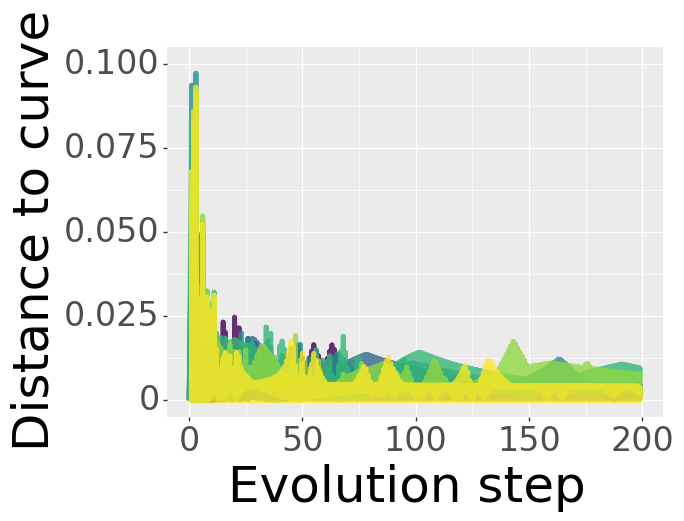

In [567]:
plot = (
    pn.ggplot(
        df_traj_analysis,
        pn.aes(
            x="iteration", 
            y="min_distance_to_curve", 
        ),
    )
    + pn.geom_line(
        pn.aes(color="discriminative_need_gamma"),
        size=2,
        alpha=0.8,
        )
    # + pn.scale_color_continuous(
        # trans = "log10",
    # )
    + pn.scale_color_manual(values = fill_values_dict)
    + pn.labs(color="$\\gamma$ (pragmatic precision)")    
    + pn.xlab("Evolution step")
    + pn.ylab("Distance to curve")
    + pn.theme(
        # Axis font
        axis_title=pn.element_text(size=36),
        axis_text=pn.element_text(size=24),
        # Legend position
        legend_position=(0.7, 0.6),
        # legend_position='none',
        legend_direction = "vertical",
        # Legend box
        legend_background=pn.element_rect(
            fill="lightgrey",
            size=0.5, linetype="solid", 
            color="darkblue",
        ),
    )
    + pn.guides(
        color = pn.guide_colorbar(
            title_position = "bottom", 
            label_position = "bottom",
            override_aes = {"alpha":0.8},
            ),
    )
    # + pn.scale_y_continuous(
        # trans='log10', 
        # limits=[1e-5, 1.],
    # )
    + pn.ylim(0,0.1)
)
print(plot)
# plot.save("distance_plot.png", width=6, height=6, dpi=300,)

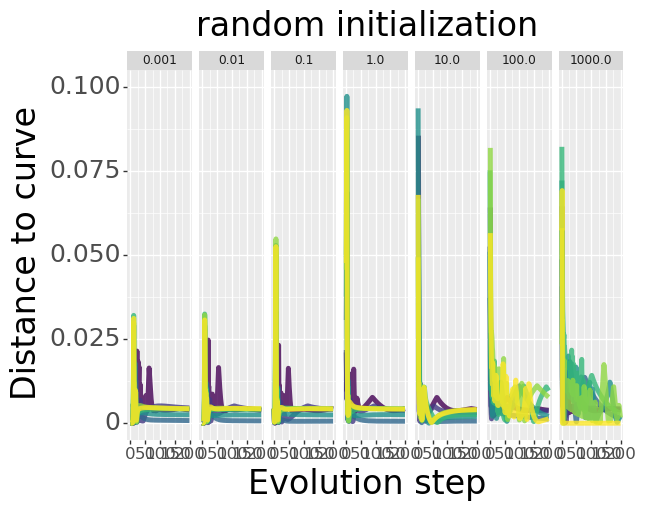

/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 18 x 6 in image.
/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: distances_plot.png


In [568]:
plot = (
    plot 
    + pn.facet_grid(". ~ population_init_gamma") 
    + pn.ggtitle("random initialization")
    + pn.theme(
        title=pn.element_text(size=24),
        axis_text_x=pn.element_text(size=12),
        axis_text_y=pn.element_text(size=18),
        legend_position='none',
    )

)

print(plot)
plot.save("distances_plot.png", width=18, height=6, dpi=300,)

Focus on one individual initialization

/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 1 rows containing missing values.
/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/plotnine/guides/guide_colorbar.py:72: PlotnineWarning: colorbar guide needs continuous scales


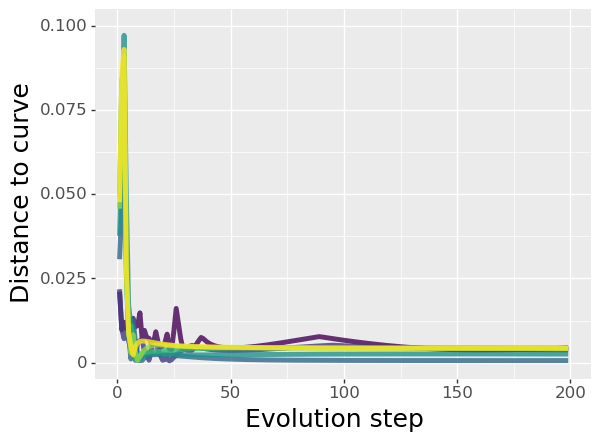

/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6 x 6 in image.
/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: distance_plot.png
/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 1 rows containing missing values.
/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/plotnine/guides/guide_colorbar.py:72: PlotnineWarning: colorbar guide needs continuous scales


In [569]:
plot = (
    pn.ggplot(
        df_traj_analysis[df_traj_analysis["population_init_gamma"] == 1.],
        pn.aes(
            x="iteration", 
            y="min_distance_to_curve", 
        ),
    )
    + pn.geom_line(
        pn.aes(color="discriminative_need_gamma"),
        size=2,
        alpha=0.8,
        )
    + pn.scale_color_manual(values = fill_values_dict)
    + pn.labs(color="$\\gamma$ (pragmatic precision)")    
    + pn.xlab("Evolution step")
    + pn.ylab("Distance to curve")
    + pn.theme(
        # Axis font
        axis_title=pn.element_text(size=18),
        axis_text=pn.element_text(size=12),
        # Legend position
        legend_position=(0.7, 0.6),
        # legend_position='none',
        legend_direction = "vertical",
        # Legend box
        legend_background=pn.element_rect(
            fill="lightgrey",
            size=0.5, linetype="solid", 
            color="darkblue",
        ),
    )
    + pn.guides(
        color = pn.guide_colorbar(
            title_position = "bottom", 
            label_position = "bottom",
            override_aes = {"alpha":0.8},
            ),
    )
    + pn.scale_y_continuous(
        # trans='log10', 
        limits=[1e-4, 0.1],
    )
    # + pn.ylim(0,0.1)
)
print(plot)
plot.save("distance_plot.png", width=6, height=6, dpi=300,)

In [570]:
(
    plot
    + pn.scale_y_continuous(
        trans='log10', 
        limits=[1e-4, 1.],
    )
    + pn.theme(
        axis_title=pn.element_blank(),
        # axis_text=pn.element_blank(),
    )
).save("distance_plot_zoomed.png", width=8, height=6, dpi=300,)

/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/plotnine/scales/scales.py:36: PlotnineWarning: Scale for 'y' is already present.
Adding another scale for 'y',
which will replace the existing scale.

/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 8 x 6 in image.
/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: distance_plot_zoomed.png
/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/plotnine/guides/guide_colorbar.py:72: PlotnineWarning: colorbar guide needs continuous scales


In [571]:
from scipy.stats import spearmanr, kendalltau

# for each gamma, compute monotonicity for min_distances
result = df_traj_analysis.groupby(gamma).apply(lambda group: kendalltau(group['min_distance_to_curve'], group['iteration'])).reset_index()
result.columns=[gamma, "result"]

In [572]:
# Extract correlation coefficients and p-values into separate columns
result[['kendall_tau', 'p_value']] = result['result'].apply(pd.Series)
result = result.drop(columns=['result'])
result

,discriminative_need_gamma,kendall_tau,p_value
0,0.001,-0.206996,5.304197e-31
1,0.01,0.031506,7.802492e-02
2,0.1,-0.237824,2.262096e-40
3,1.0,-0.114429,1.553734e-10
4,10.0,-0.057297,1.351922e-03
5,100.0,-0.177237,3.643765e-23
6,1000.0,-0.173624,6.058584e-22


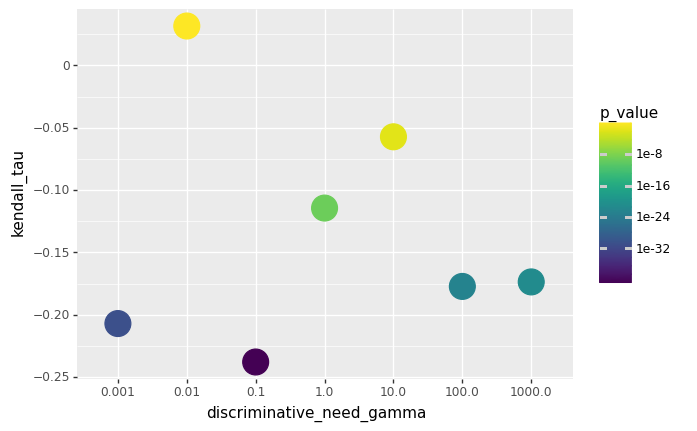

<ggplot: (736319149)>

In [573]:
(
    pn.ggplot(
        result,
        pn.aes(x=gamma, y="kendall_tau", color="p_value")
    )
    + pn.scale_color_continuous(
        trans = "log10",
    )
    + pn.geom_point(size=10)
)

Try to get some trajectories

In [574]:

df_traj_ = df_traj_analysis[df_traj_analysis["population_init_gamma"] == 1.]
df_final_ = df_final_points[df_final_points["population_init_gamma"] == 1.]

(
    # Set data and the axes
    pn.ggplot(
        data=df_ib_bound, mapping=pn.aes(x="complexity", y="accuracy")
    )
    # + pn.geom_point(size=1)
    + pn.geom_line(size=3) # IB curve
    + pn.geom_ribbon(
    mapping=pn.aes(
        x="complexity",
        ymin="accuracy",
        ymax=torch.inf,
        ),
        fill="gray",
        alpha=0.3,
    )
    + pn.geom_line( # trajectories
    # + pn.geom_line(
        data=df_traj_,
        mapping=pn.aes(
            color=gamma,
            ),
        alpha=0.8,
        size=2,
    )
    + pn.geom_point( # Final points
    # + pn.geom_line(
        data=df_final_,
        mapping=pn.aes(
            color=gamma,
            ),
        # alpha=0.8,
        size=5,
        shape="X",
    )    
    + pn.scale_color_manual(values = fill_values_dict)
    + pn.labs(color="$\\gamma$ (pragmatic precision)")    

    # + pn.xlim([0,np.log2(100)])
    + pn.xlim([0., 3.2,])    
    + pn.ylim([0., 3.,])
    + pn.xlab("Complexity, $I(M;W)$ bits")
    + pn.ylab("Accuracy, $I(W;U)$ bits")

    + pn.theme_classic()
    + pn.theme(
        # Axis font
        axis_title=pn.element_text(size=18),
        axis_text=pn.element_text(size=12),
        # Legend position
        # legend_position=(0.75, 0.45),
        legend_position='none',
        legend_direction = "vertical",
        # Legend box
        legend_background=pn.element_rect(
            fill="lightgrey",
            size=0.5, linetype="solid", 
            color="darkblue",
        ),
    )
    + pn.guides(
        # fill = pn.guide_legend(
        fill = pn.guide_colorbar(
            title_position = "bottom", 
            # hjust = 0.5 centers the title horizontally
            title_hjust = 0.8,
            title_vjust = 2.,
            label_position = "bottom",
            override_aes = {"alpha":0.8},
            # nrow=3,
            ),
    ) 
).save("trajectory_plot_zoomed.png", width=8, height=6, dpi=300,)

/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 8 x 6 in image.
/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: trajectory_plot_zoomed.png
/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 726 rows containing missing values.
